# Проект по А/B-тестированию

Цель исследования - провести оценку результатов A/B-теста. 
- Оценить корректность проведения теста.
- Проанализировать результаты теста.

Данные: датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.



Описание данных

 - /datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;

Структура файла:
    - name — название маркетингового события;
    - regions — регионы, в которых будет проводиться рекламная кампания;
    - start_dt — дата начала кампании;
    - finish_dt — дата завершения кампании.

- /datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:
    - user_id — идентификатор пользователя;
    - first_date — дата регистрации;
    - region — регион пользователя;
    - device — устройство, с которого происходила регистрация.

- /datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:
    - user_id — идентификатор пользователя;
    - event_dt — дата и время события;
    - event_name — тип события;
    - details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

- /datasets/final_ab_participants.csv — таблица участников тестов.

Структура файла:
    - user_id — идентификатор пользователя;
    - ab_test — название теста;
    - group — группа пользователя.

## Загрузка данных и подготовка их к анализу.

###  *Загрузить данные.*

In [1]:
#импорт библиотек

import pandas as pd
import datetime as dt
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math
import scipy.stats as stats


In [2]:
#чтение файлов с данными и сохранение в соответствующую переменную
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv') 
users = pd.read_csv('/datasets/final_ab_new_users.csv', sep=',') 
events = pd.read_csv('/datasets/final_ab_events.csv', sep=',') 
participants = pd.read_csv('/datasets/final_ab_participants.csv', sep=',') 

In [3]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


###  *Предобработка данных.*

#### Проверка типа данных

In [7]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [9]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Необходимо перевести в тип дата данные столбцов:

датасет marketing_events
- 'start_dt' 
- 'finish_dt'

датасет users
- 'first_date'

датасет events
- 'event_dt'

In [11]:
# преобразование данных о времени
time_format = "%Y-%m-%d %H:%M:%S"
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format = time_format)
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format = time_format)
users['first_date'] = pd.to_datetime(users['first_date'], format = time_format)
events['event_dt'] = pd.to_datetime(events['event_dt'], format = time_format)


In [12]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [14]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


#### Пропуски в датафреймах

In [15]:
#подсчет пропусков
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [16]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [17]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [18]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [19]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [20]:
events.groupby('event_name')['details'].mean()

event_name
login                 NaN
product_cart          NaN
product_page          NaN
purchase        23.877631
Name: details, dtype: float64

Обнаружено очень много пропусков в датасете events столбец 'details'. Сгруппировав по столбцу 'details' видно, что данные заполнены только по типу события purchase, в этом поле хранится стоимость покупки в долларах, а остальные события не имеют стоимости, поэтому не заполнены. Для удобства заменим их нулями.

In [21]:
events.loc[events['details'].isna(), 'details'] = 0

In [22]:
events.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

Итак, пропущенные значения мы проработали.

#### Дубликаты в датафреймах

Подсчитаем явные дубликаты.

In [23]:
#подсчет явных дубликатов
marketing_events.duplicated().sum()

0

In [24]:
users.duplicated().sum()

0

In [25]:
events.duplicated().sum()

0

In [26]:
participants.duplicated().sum()

0

Таким образом, дубликатов в данных не обнаружено.

#### *Дополнительные проверки данных.*

In [27]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [28]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [29]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [30]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


#####  Категориальные переменные

Проверим категориальные переменные на корректность их написание.

In [31]:
marketing_events['name'].value_counts()

Black Friday Ads Campaign           1
Chinese Moon Festival               1
International Women's Day Promo     1
St. Valentine's Day Giveaway        1
Labor day (May 1st) Ads Campaign    1
Dragon Boat Festival Giveaway       1
St. Patric's Day Promo              1
CIS New Year Gift Lottery           1
Single's Day Gift Promo             1
4th of July Promo                   1
Chinese New Year Promo              1
Victory Day CIS (May 9th) Event     1
Christmas&New Year Promo            1
Easter Promo                        1
Name: name, dtype: int64

In [32]:
marketing_events['regions'].value_counts()

APAC                        4
EU, CIS, APAC, N.America    3
CIS                         2
EU, N.America               2
EU, CIS, APAC               2
N.America                   1
Name: regions, dtype: int64

In [33]:
users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [34]:
users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [35]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [36]:
participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

In [37]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Проверка категорийных данных не обнаружело каких-либо описок или ошибок в них.

##### Численные данные.

Численными данными в данных датасетах будем считать информацию по датам - проверим их на наличие каких-то ошибок или аномалий

Логично, что в датасете marketing_events столбец start_dt — дата начала кампании было раньше, чем столбец finish_dt — дата завершения кампании, поэтому оно должно быть меньше. Проверим: 

In [38]:
marketing_events[marketing_events['finish_dt']< marketing_events['start_dt']].count()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Итак, аномалий в числовых данных не обнаружено.

Вывод по п.1:

В данном пункте исследования были загружены основные данные и проведены следующие проверки:

1) Переведены в тип дата:

датасет marketing_events
- 'start_dt' 
- 'finish_dt'

датасет users
- 'first_date'

датасет events
- 'event_dt'

2) Обнаружено очень много пропусков в датасете events столбец 'details'. Сгруппировав по столбцу 'details' видно, что данные заполнены только по типу события purchase, в этом поле хранится стоимость покупки в долларах, а остальные события не имеют стоимости, поэтому не заполнены. Для удобства заменим их нулями.

3) Проверка наличия явных дубликатов в данных их не обнаружела.

4) Проверка категорийных и численных данных показала отсутсвие описок, ошибок или других аномалий.



## Оценка корректность проведения теста.

Техническое задание

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
   - конверсии в просмотр карточек товаров — событие product_page
   - просмотры корзины — product_cart
   - покупки — purchase.

В данном пункте исследования необходимо проверить:

- Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
- Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
- Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.

### Пересечение тестовой аудитории с конкурирующим тестом.

- Название теста: recommender_system_test.

In [39]:
participants.count()

user_id    18268
group      18268
ab_test    18268
dtype: int64

Проверим пересечение тестовой аудитории с конкурирующим тестом.

In [40]:
#выделим в датасет данные по тесту recommender_system_test
rec_sys = participants.loc[participants['ab_test'] == 'recommender_system_test']
rec_sys.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [41]:
#выделим в датасет данные по тесту interface_eu_test 
int_t = participants.loc[participants['ab_test'] != 'recommender_system_test']
int_t.head()

,user_id,group,ab_test
6701,D4E530F6595A05A3,A,interface_eu_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6703,6BCB0F33D3BAB8C2,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test


In [42]:
#найдем пересечение по пользователям в группах
s1 = pd.merge(rec_sys, int_t, on=['user_id'], how='inner')
s1

,user_id,group_x,ab_test_x,group_y,ab_test_y
0,DABC14FDDFADD29E,A,recommender_system_test,A,interface_eu_test
1,04988C5DF189632E,A,recommender_system_test,A,interface_eu_test
2,B3A2485649E4A012,A,recommender_system_test,A,interface_eu_test
3,EAFB9027A27D510C,B,recommender_system_test,A,interface_eu_test
4,5D5E6EE92AF6E9E0,B,recommender_system_test,B,interface_eu_test
...,...,...,...,...,...
1597,C2DC7B6881CE6E30,B,recommender_system_test,B,interface_eu_test
1598,EA29547AB3C0CB9C,B,recommender_system_test,A,interface_eu_test
1599,9A44E27079666291,B,recommender_system_test,A,interface_eu_test
1600,FA86D8DFAD3ADADE,A,recommender_system_test,A,interface_eu_test


Пересечение найдено - это 1602 строки в данных, где один пользователь попадает и в тест recommender_system_test и в тест nterface_eu_test. Так как эти два теста ялвются конкурирующими: оба связаны с интерфейсом, то наличие таких данных может искозить результат. Поэтому было принято решение: удалить данные по этим пользователям.

In [43]:
participants.drop(s1.index, axis=0, inplace=True)

In [44]:

participants.count()

user_id    16666
group      16666
ab_test    16666
dtype: int64

### Временные границы теста.

- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;

При определении длительности теста важно понимать, какие всплески активности бывают у вашей аудитории.
Поэтому при анализе данного исследования необходимо учитывать возможные причины всплесков, в связи:
- Выходные: 12, 13, 19, 20, 26, 27 декабря 2020 года. 
- Праздники: 1, 2, 3, 4 января 2021 года. Период для исследования выбран некорректно, целесообразнее было бы перенести его проведение после 10 января.
- Маркетинговые активности (скидки увеличивают активность аудитории, меняя её покупательское поведение).

Так же необходимо проверить, что:
 - период регистрации всех новых пользователей находится между 7 и 21 декабря 2020 года.
 - данные заканчиваются 4 января 2021 года.


#### Маркетинговые активности.

Найдем периоды маркетинговых активностей и сосставим их с интервалом проведения теста.

In [45]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [46]:
marketing_events.groupby(['start_dt', 'finish_dt']).agg({'name':'nunique'})


,,name
start_dt,finish_dt,
2020-01-25,2020-02-07,1
2020-02-14,2020-02-16,1
2020-03-08,2020-03-10,1
2020-03-17,2020-03-19,1
2020-04-12,2020-04-19,1
2020-05-01,2020-05-03,1
2020-05-09,2020-05-11,1
2020-06-25,2020-07-01,1
2020-07-04,2020-07-11,1


Видим, что в период проведения теста попали две маркетинговые активности: 

- 2020-12-25	2021-01-03
- 2020-12-30	2021-01-07

То есть, при анализе исследования нужно помнить, что в  период с 25.12.2020 по 04.01.2021  - проводились маркетинговые активности.

#### Периоды проведения теста.

- Проверим, что период регистрации всех новых пользователей находится между 7 и 21 декабря 2020 года.

In [47]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [48]:
#найдем пользователей, которые зарегистрировались после 21.12.2020г
users.loc[users['first_date'] > '2020-12-21', 'user_id'].nunique()

5263

Обнаружено 5 263 пользователя, которые зарегистрировались после 21.12.2020г. Это достаточно большое колличество неоткорректированных данных, которые скорее всего искозят в дальнейшем результаты теста.

- Проверим, что данные заканчиваются 4 января 2021 года.

In [49]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [50]:
events.loc[events['event_dt'] > '2021-01-04', 'user_id'].nunique()

0

Итак, событий, превышающих время остановки теста не обнаружено.

### *Аудиторию теста*

#### Пересечение в пользователях.

Проверим группы А и В на наличие пересечений в пользователях.

In [52]:
#выделим в датасет данные по тесту recommender_system_test
rec_sys_2 = participants.loc[participants['ab_test'] == 'recommender_system_test']
rec_sys_2.head()

,user_id,group,ab_test
1602,526BA4A669CC6CC2,A,recommender_system_test
1603,D2D3509933B9D5F3,A,recommender_system_test
1604,D6A6592338A322B0,A,recommender_system_test
1605,95A9423B37553B4B,A,recommender_system_test
1606,822A4D7433FDF914,A,recommender_system_test


In [53]:
#разделим общий датафрейм по группам А и В
rec_sysA = rec_sys_2.loc[rec_sys['group'] == 'A']
rec_sysB = rec_sys_2.loc[rec_sys['group'] != 'A']
display(rec_sysA.head())
display(rec_sysB.head())

,user_id,group,ab_test
1602,526BA4A669CC6CC2,A,recommender_system_test
1603,D2D3509933B9D5F3,A,recommender_system_test
1604,D6A6592338A322B0,A,recommender_system_test
1605,95A9423B37553B4B,A,recommender_system_test
1606,822A4D7433FDF914,A,recommender_system_test


,user_id,group,ab_test
1608,75895B243932CA83,B,recommender_system_test
1610,95641DE55C19FB61,B,recommender_system_test
1611,58413BED951516D5,B,recommender_system_test
1618,6DEEABA508AAD2A7,B,recommender_system_test
1619,29535733A8B8C27A,B,recommender_system_test


In [54]:
#найдем пересечение по пользователям в группах
s2 = pd.merge(rec_sysA, rec_sysB, on=['user_id'], how='inner')
s2

,user_id,group_x,ab_test_x,group_y,ab_test_y


Пересечение пользователей Группы: А (контрольная), B (новая платёжная воронка) не обнаружено.

#### Аудитория из региона EU.

- Аудитория: 15% новых пользователей из региона EU - проверим этот пункт ТЗ;

In [55]:
#датасет с пользователями теста recommender_system_test
rec_sys_2.head()

,user_id,group,ab_test
1602,526BA4A669CC6CC2,A,recommender_system_test
1603,D2D3509933B9D5F3,A,recommender_system_test
1604,D6A6592338A322B0,A,recommender_system_test
1605,95A9423B37553B4B,A,recommender_system_test
1606,822A4D7433FDF914,A,recommender_system_test


In [56]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [57]:
#объединим датасеты по тесту recommender_system_test и пользователей
test_new_users = rec_sys_2.merge(users, on = 'user_id', how = 'left')
test_new_users.head()

,user_id,group,ab_test,first_date,region,device
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac
1,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21,EU,iPhone
2,D6A6592338A322B0,A,recommender_system_test,2020-12-13,EU,Android
3,95A9423B37553B4B,A,recommender_system_test,2020-12-07,EU,Android
4,822A4D7433FDF914,A,recommender_system_test,2020-12-10,EU,Android


In [58]:
#в датасете пользоваталей выделим пользователей, 
#зарегистрированных в период с 7 по 21 декабря и из региона EU
users.loc[(users['region'] == 'EU') & (users['first_date'] <= '2020-12-21'),'user_id'].count()

42340

In [59]:
#в датасете по тесту recommender_system_test находим пользователей из региона EU
test_new_users.loc[test_new_users['region'] == 'EU','user_id'].count()

4749

In [60]:
#находим фактическую долю пользователей из региона EU в тесте recommender_system_test 
#в общем кол-ве таких пользователей  
(test_new_users.loc[test_new_users['region'] == 'EU','user_id'].count() /\
users.loc[users['region'] == 'EU','user_id'].count())*100

10.263669764426194

Согласно расчетам данных: аудитория новых пользователей из региона EU составила 10%, а не 15%, как было заявлено в ТЗ.

#### Ожидаемое количество участников теста.

- Ожидаемое количество участников теста: 6000 - проверим согласно данным.

In [64]:
#датасет новых пользователей теста recommender_system_test
test_new_users.head()

,user_id,group,ab_test,first_date,region,device
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac
1,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21,EU,iPhone
2,D6A6592338A322B0,A,recommender_system_test,2020-12-13,EU,Android
3,95A9423B37553B4B,A,recommender_system_test,2020-12-07,EU,Android
4,822A4D7433FDF914,A,recommender_system_test,2020-12-10,EU,Android


In [65]:
#объединим новых пользователей теста recommender_system_test с их событиями
test_new_users_ev = test_new_users.merge(events, on = 'user_id', how = 'left')
test_new_users_ev.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 05:00:29,product_cart,0.0
1,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-23 09:46:55,product_cart,0.0
2,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 05:00:25,login,0.0
3,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-23 09:46:53,login,0.0
4,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21,EU,iPhone,2020-12-21 20:32:41,product_cart,0.0


In [66]:
#выделим столбец first_date_14day - дата 14 дней после регистрации
test_new_users_ev['first_date_14day'] = test_new_users_ev['first_date'] +timedelta(days=14)
test_new_users_ev.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,first_date_14day
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 05:00:29,product_cart,0.0,2021-01-04
1,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-23 09:46:55,product_cart,0.0,2021-01-04
2,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 05:00:25,login,0.0,2021-01-04
3,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-23 09:46:53,login,0.0,2021-01-04
4,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21,EU,iPhone,2020-12-21 20:32:41,product_cart,0.0,2021-01-04


In [67]:
#найдем количество пользователей, события которых совершены не позже, чем через 14 дней 
#после их регистрации
test_new_users_ev = test_new_users_ev.loc[test_new_users_ev['event_dt'] <= test_new_users_ev['first_date_14day']]
test_new_users_ev.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,first_date_14day
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 05:00:29,product_cart,0.0,2021-01-04
1,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-23 09:46:55,product_cart,0.0,2021-01-04
2,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 05:00:25,login,0.0,2021-01-04
3,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-23 09:46:53,login,0.0,2021-01-04
4,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21,EU,iPhone,2020-12-21 20:32:41,product_cart,0.0,2021-01-04


In [68]:
display((test_new_users_ev['user_id']).nunique())

2815

In [69]:
6000 - (test_new_users_ev.loc[test_new_users_ev['event_dt']\
                               <= test_new_users_ev['first_date_14day'], 'user_id']).nunique()

3185

Количество участников теста составило 2815 человек - это на 3185 человек меньше ожидаемого.

### Распределения событий по тестовым группам

#### Количество событий на пользователя.

In [70]:
rec_sys_2.head()

,user_id,group,ab_test
1602,526BA4A669CC6CC2,A,recommender_system_test
1603,D2D3509933B9D5F3,A,recommender_system_test
1604,D6A6592338A322B0,A,recommender_system_test
1605,95A9423B37553B4B,A,recommender_system_test
1606,822A4D7433FDF914,A,recommender_system_test


In [71]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [72]:
#объединим два датасета: данные теста и события
rec_sys_ev = rec_sys_2.merge(events, on = 'user_id', how = 'left')
rec_sys_ev.head()

,user_id,group,ab_test,event_dt,event_name,details
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21 05:00:29,product_cart,0.0
1,526BA4A669CC6CC2,A,recommender_system_test,2020-12-23 09:46:55,product_cart,0.0
2,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21 05:00:25,login,0.0
3,526BA4A669CC6CC2,A,recommender_system_test,2020-12-23 09:46:53,login,0.0
4,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21 20:32:41,product_cart,0.0


In [73]:
#разделим на тестовые группы
rec_sys_evA = rec_sys_ev.loc[rec_sys_ev['group'] == 'A']
rec_sys_evB = rec_sys_ev.loc[rec_sys_ev['group'] != 'A']
display(rec_sys_evA.head())
display(rec_sys_evB.head())

,user_id,group,ab_test,event_dt,event_name,details
0,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21 05:00:29,product_cart,0.0
1,526BA4A669CC6CC2,A,recommender_system_test,2020-12-23 09:46:55,product_cart,0.0
2,526BA4A669CC6CC2,A,recommender_system_test,2020-12-21 05:00:25,login,0.0
3,526BA4A669CC6CC2,A,recommender_system_test,2020-12-23 09:46:53,login,0.0
4,D2D3509933B9D5F3,A,recommender_system_test,2020-12-21 20:32:41,product_cart,0.0


,user_id,group,ab_test,event_dt,event_name,details
23,75895B243932CA83,B,recommender_system_test,NaT,NaN,NaN
36,95641DE55C19FB61,B,recommender_system_test,NaT,NaN,NaN
37,58413BED951516D5,B,recommender_system_test,NaT,NaN,NaN
51,6DEEABA508AAD2A7,B,recommender_system_test,NaT,NaN,NaN
52,29535733A8B8C27A,B,recommender_system_test,NaT,NaN,NaN


In [74]:
#распределим количество событий на пользователя группы А 
rA = rec_sys_evA.groupby('user_id', as_index=False)[['event_name']].nunique()
rA = rA.loc[rA['event_name'] !=0]
rA 

,user_id,event_name
1,0010A1C096941592,3
2,00341D8401F0F665,1
4,003DF44D7589BBD4,3
5,00505E15A9D81546,1
6,006E3E4E232CE760,2
...,...,...
2899,FF40F25452E70E3D,2
2900,FF5A1CD38F5DD996,2
2901,FF5B24BCE4387F86,3
2902,FF825C1D791989B5,2


In [75]:
# проверим распределение количества событий на пользователя группы А на нормальность, 
#используя критерий Шапиро-Уилка.
from scipy import stats as st

sales_data = rA['event_name']

alpha = 0.05 # ваш код

results = st.shapiro(sales_data)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  6.402870396429991e-39
Отвергаем нулевую гипотезу: распределение не нормально


In [76]:
#распределим количество событий на пользователя группы В 
rB = rec_sys_evB.groupby(['user_id'], as_index=False)[['event_name']].nunique()
rB = rB.loc[rB['event_name'] !=0]

rB

,user_id,event_name
0,005E096DBD379BCF,2
5,015D1E3BB893349D,2
6,015FF3EC72C1F4F6,2
7,01B0B891CA513468,3
10,01C17F099908DA14,1
...,...,...
2175,FDF5D9D1B047FA31,2
2178,FE244437A4224900,2
2181,FE8F9858BBE502D9,2
2189,FF8CF7057415EB29,2


In [77]:
# проверим распределение пользователей группы В по событиям на нормальность, 
#используя критерий Шапиро-Уилка.

from scipy import stats as st

sales_data = rB['event_name']

alpha = 0.05 # ваш код

results = st.shapiro(sales_data)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  1.7460996347112436e-24
Отвергаем нулевую гипотезу: распределение не нормально


Итак, распределения событий по пользователям в обеих тестовых группах будем считать не нормальным.

In [78]:
rA.describe()

,event_name
count,2109.000000
mean,2.282124
std,0.841617
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


In [79]:
rB.describe()

,event_name
count,706.000000
mean,2.131728
std,0.856141
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


array([[<AxesSubplot:title={'center':'event_name'}>]], dtype=object)

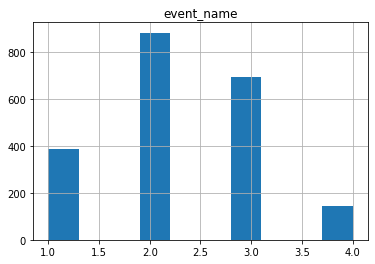

In [80]:
rA.hist()

array([[<AxesSubplot:title={'center':'event_name'}>]], dtype=object)

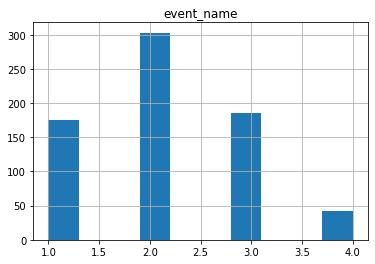

In [81]:
rB.hist()

Сравнивая распределение количества событий в разрезе групп видим, что после внедрением улучшенной рекомендательной системы пользователи стали совершать меньшее количество событий.

####  Количество событий  по дням.

In [82]:
#распределим количество событий по дням группы А 
rA_1 = rec_sys_evA.groupby('event_dt', as_index=False)[['event_name']].count()
rA_1

,event_dt,event_name
0,2020-12-07 00:14:01,2
1,2020-12-07 00:31:08,2
2,2020-12-07 00:39:13,1
3,2020-12-07 00:39:14,1
4,2020-12-07 00:39:18,1
...,...,...
9854,2020-12-29 23:36:20,1
9855,2020-12-29 23:38:09,1
9856,2020-12-29 23:38:10,1
9857,2020-12-29 23:38:28,1


In [83]:
# проверим распределение количества событий по дням группы А на нормальность, 
#используя критерий Шапиро-Уилка.
from scipy import stats as st

sales_data = rA_1['event_name']

alpha = 0.05 # ваш код

results = st.shapiro(sales_data)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [84]:
#распределим количество событий по дням группы В 
rB_1 = rec_sys_evB.groupby('event_dt', as_index=False)[['event_name']].count()
rB_1

,event_dt,event_name
0,2020-12-07 00:05:57,2
1,2020-12-07 00:07:47,2
2,2020-12-07 00:07:48,1
3,2020-12-07 00:07:49,1
4,2020-12-07 00:25:02,2
...,...,...
2901,2020-12-29 22:17:13,1
2902,2020-12-29 23:24:34,1
2903,2020-12-29 23:27:00,1
2904,2020-12-30 12:42:56,1


In [85]:
# проверим распределение количества событий по дням группы B на нормальность, 
#используя критерий Шапиро-Уилка.
from scipy import stats as st

sales_data = rB_1['event_name']

alpha = 0.05 # ваш код

results = st.shapiro(sales_data)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [86]:
rA_1.describe()

,event_name
count,9859.000000
mean,1.515164
std,0.719020
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


In [87]:
rB_1.describe()

,event_name
count,2906.000000
mean,1.419133
std,0.650035
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


Можно сделать вывод, что количество событий, в связи с внедрением улучшенной рекомендательной системы, значительно уменьшилось, но распределение их по датам не очень изменилось. 

Вывод п.2:

После оценки корректности проведения теста можно сделать вывод данные не достаточно корректны:

- временные границы проведения теста выбраны неверно:
    - выпадают на предпраздничные и праздничные дни;
    - совпадают с датами проведения маркетинговых активностей;
    - обнаружено 5 263 пользователя, которые зарегистрировались после 21.12.2020г.
    
- аудитория теста тоже не совпадает с ожидаемой;

- сравнивая распределение количества событий в разрезе групп видим, что после внедрением улучшенной рекомендательной системы пользователи стали совершать меньшее количество событий, особенности они перестали покупать;

- количество событий, в связи с внедрением улучшенной рекомендательной системы, значительно уменьшилось, но распределение их по датам не очень изменилось.


## Cтатистическая значимость различий в конверсии между группами.

Сначала объединим необходимые нам датасеты.

In [88]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [89]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [90]:
ev_us = events.merge(users, on = 'user_id', how = 'left')
ev_us.head()

,user_id,event_dt,event_name,details,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,N.America,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android


In [91]:
rec_sys_2.head()

,user_id,group,ab_test
1602,526BA4A669CC6CC2,A,recommender_system_test
1603,D2D3509933B9D5F3,A,recommender_system_test
1604,D6A6592338A322B0,A,recommender_system_test
1605,95A9423B37553B4B,A,recommender_system_test
1606,822A4D7433FDF914,A,recommender_system_test


In [92]:
par_ev_us = ev_us.merge(rec_sys_2, on = 'user_id', how = 'left')
par_ev_us.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,N.America,iPhone,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,NaN,NaN
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android,NaN,NaN


Теперь отсортируем данные по признаку: за 14 дней с момента регистрации в системе. То есть найдем тех пользователей, дата регистрации которых превышает 2020-12-21, и удалить их. 

In [93]:
par_ev_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440317 entries, 0 to 440316
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
 4   first_date  440317 non-null  datetime64[ns]
 5   region      440317 non-null  object        
 6   device      440317 non-null  object        
 7   group       19062 non-null   object        
 8   ab_test     19062 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 33.6+ MB


In [94]:
p1 = par_ev_us[par_ev_us['first_date'] > '2020-12-21']
p1

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
44368,5A5833D3AEA75255,2020-12-22 23:18:38,purchase,4.99,2020-12-22,N.America,PC,NaN,NaN
44369,C32160D27E0B2324,2020-12-22 13:37:16,purchase,9.99,2020-12-22,N.America,Mac,NaN,NaN
44370,8AC580EDB35E2FF1,2020-12-22 02:30:07,purchase,9.99,2020-12-22,EU,Android,NaN,NaN
44371,E5467571E29E4A19,2020-12-22 04:14:04,purchase,4.99,2020-12-22,EU,iPhone,NaN,NaN
44372,2D0492BE083C2C9E,2020-12-22 04:23:04,purchase,499.99,2020-12-22,EU,Android,NaN,NaN
...,...,...,...,...,...,...,...,...,...
438413,A801F4F14C543707,2020-12-29 03:09:53,login,0.00,2020-12-23,N.America,PC,NaN,NaN
438414,69991E6AE74B5C8B,2020-12-29 19:10:53,login,0.00,2020-12-23,EU,iPhone,NaN,NaN
438415,DAEF8CF6E253DBCE,2020-12-29 22:46:23,login,0.00,2020-12-23,EU,Android,NaN,NaN
438416,32A46395A711AEFF,2020-12-29 07:51:45,login,0.00,2020-12-23,EU,iPhone,NaN,NaN


In [95]:
par_ev_us.drop(p1.index, axis=0, inplace=True)

In [96]:
par_ev_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407750 entries, 0 to 440316
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     407750 non-null  object        
 1   event_dt    407750 non-null  datetime64[ns]
 2   event_name  407750 non-null  object        
 3   details     407750 non-null  float64       
 4   first_date  407750 non-null  datetime64[ns]
 5   region      407750 non-null  object        
 6   device      407750 non-null  object        
 7   group       19062 non-null   object        
 8   ab_test     19062 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 31.1+ MB


Итак, получили отфильтрованный по дате регистрации (с 7 по 21 декабря) датасет par_ev_us, который мы будем использовать для анализа дальше.

### Воронка событий.

Найдем воронку событий и расчитаем конверсии к ним:

- login - product_page
- login - produc_cart
- login - purchase

I) login - product_page

ГРУППА "А"

In [97]:
#найдем кол-во пользователей группы A, совершивших событие login, сохраним в переменной us_l_A
us_l_A = par_ev_us.loc[(par_ev_us['event_name'] == 'login') \
              & (par_ev_us['group'] == 'A'), 'user_id'].nunique()
us_l_A

2109

In [98]:
#найдем кол-во пользователей группы A, совершивших событие product_page, сохраним в переменной us_pp_A

us_pp_A = par_ev_us.loc[(par_ev_us['event_name'] == 'product_page') \
              & (par_ev_us['group'] == 'A'), 'user_id'].nunique()
us_pp_A

1366

In [99]:
#найдем конверсию количества пользователей login - в количество пользователей product_page

con_l_pp_A = round((us_pp_A / us_l_A) * 100, 2)
con_l_pp_A


64.77

Итак, конверсия воронки событий login - product_page пользователей группы А равна 64,77%.  


ГРУППА "В"

In [100]:
#найдем кол-во пользователей группы B, совершивших событие login, сохраним в переменной us_l_B
us_l_B = par_ev_us.loc[(par_ev_us['event_name'] == 'login') \
              & (par_ev_us['group'] == 'B'), 'user_id'].nunique()
us_l_B

706

In [101]:
#найдем кол-во пользователей группы B, совершивших событие product_page, сохраним в переменной us_pp_B

us_pp_B = par_ev_us.loc[(par_ev_us['event_name'] == 'product_page') \
              & (par_ev_us['group'] == 'B'), 'user_id'].nunique()
us_pp_B

401

In [102]:
#найдем конверсию количества пользователей login - в количество пользователей product_page

con_l_pp_B = round((us_pp_B / us_l_B) * 100, 2)
con_l_pp_B


56.8

Итак, конверсия воронки событий login - product_page пользователей группы B равна 56,8%.  


II) login - produc_cart

ГРУППА "А"

In [103]:
#найдем кол-во пользователей группы A, совершивших событие produc_cart, сохраним в переменной us_pc_A
us_pc_A = par_ev_us.loc[(par_ev_us['event_name'] == 'product_cart') \
              & (par_ev_us['group'] == 'A'), 'user_id'].nunique()
us_pc_A

656

In [104]:
#найдем конверсию количества пользователей login - в количество пользователей produc_cart

con_l_pc_A = round((us_pc_A / us_l_A) * 100, 2)
con_l_pc_A


31.1

Итак, конверсия воронки событий login - produc_cart пользователей группы A равна 31,1%. 

ГРУППА "B"

In [105]:
#найдем кол-во пользователей группы B, совершивших событие produc_cart, сохраним в переменной us_pc_B
us_pc_B = par_ev_us.loc[(par_ev_us['event_name'] == 'product_cart') \
              & (par_ev_us['group'] == 'B'), 'user_id'].nunique()
us_pc_B

207

In [106]:
#найдем конверсию количества пользователей login - в количество пользователей produc_cart

con_l_pc_B = round((us_pc_B / us_l_B) * 100, 2)
con_l_pc_B

29.32

Итак, конверсия воронки событий login - produc_cart пользователей группы B равна 29,32%. 

III) login - purchase

ГРУППА "А"

In [107]:
par_ev_us.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,N.America,iPhone,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,NaN,NaN
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android,NaN,NaN


In [108]:
#найдем кол-во пользователей группы A, совершивших событие purchase, сохраним в переменной us_p_A
us_p_A = par_ev_us.loc[(par_ev_us['event_name'] == 'purchase') \
              & (par_ev_us['group'] == 'A') & (par_ev_us['details'] != 0), 'user_id'].nunique()
us_p_A

682

In [109]:
#найдем конверсию количества пользователей login - в количество пользователей purchase

con_l_p_A = round((us_p_A / us_l_A) * 100, 2)
con_l_p_A

32.34

Итак, конверсия воронки событий login - purchase пользователей группы A равна 32,34%.

ГРУППА "B"

In [110]:
#найдем кол-во пользователей группы B, совершивших событие purchase, сохраним в переменной us_p_B
us_p_B = par_ev_us.loc[(par_ev_us['event_name'] == 'purchase') \
              & (par_ev_us['group'] == 'B') & (par_ev_us['details'] != 0), 'user_id'].nunique()
us_p_B

191

In [111]:
#найдем конверсию количества пользователей login - в количество пользователей purchase

con_l_p_B = round((us_p_B / us_l_B) * 100, 2)
con_l_p_B

27.05

Итак, конверсия воронки событий login - purchase пользователей группы B равна 27,05%.

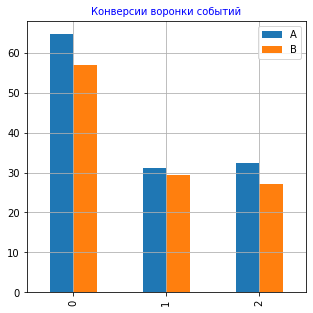

In [112]:
index = np.arange(5)

data = {'A': [con_l_pp_A, con_l_pc_A, con_l_p_A],
        'B': [con_l_pp_B, con_l_pc_B, con_l_p_B],
        }
df = pd.DataFrame(data)
df.plot(kind='bar', grid=True, figsize=(5, 5))

plt.title('Конверсии воронки событий', fontsize = 10, color = 'blue')

plt.show()

Итак, судя по гистограмме выше, можно сказать, что введение улучшенной рекомендательной системы  ухудшело показатели конверсии воронки событий в целом.

### Различия в конверсиях.

Проверим: 

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

I) login - product_page

1) Сформулируем нулевую гипотезу (Н0):
"Конверсии между группами одинаковые"

2) Альтернативная гипотеза (Н1):
"Конверсии между группами различны"

In [114]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу
count = [us_pp_A, us_pp_B] 

nobs = [us_l_A, us_l_B]
stat, pval = proportions_ztest(count, nobs)


print('p-значение: ','{0:0.3f}'.format(pval))

if pval < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 



p-значение:  0.000
Отвергаем нулевую гипотезу


Итак, конверсии между группами различны.

Найдем относительное их различие.

In [115]:
# конверсия группы В
(us_pp_B / us_l_B)*100

56.798866855524075

In [116]:
# конверсия группы А
(us_pp_A / us_l_A)*100

64.77003319108582

In [117]:
#прирост конверсии
(((us_pp_B / us_l_B) - (us_pp_A / us_l_A)) / (us_pp_A/ us_l_A)) * 100

-12.306873939750888

То есть конверсия из событий login - в событие product_page показало уменьшение на 12%. Это не соответствет ожидаемому от теста результату.

II) login - produc_cart

1) Сформулируем нулевую гипотезу (Н0):
"Конверсии между группами одинаковые"

2) Альтернативная гипотеза (Н1):
"Конверсии между группами различны"

In [118]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу
count = [us_pc_A, us_pc_B] 

nobs = [us_l_A, us_l_B]
stat, pval = proportions_ztest(count, nobs) 


print('p-значение: ','{0:0.3f}'.format(pval))

if pval < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 



p-значение:  0.373
Не получилось отвергнуть нулевую гипотезу


Итак, конверсии между группами равны.

III) login - purchase

1) Сформулируем нулевую гипотезу (Н0):
"Конверсии между группами одинаковые"

2) Альтернативная гипотеза (Н1):
"Конверсии между группами различны"

In [119]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу
count = [us_p_A, us_p_B] 

nobs = [us_l_A, us_l_B]
stat, pval = proportions_ztest(count, nobs) 


print('p-значение: ','{0:0.3f}'.format(pval))

if pval < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение:  0.009
Отвергаем нулевую гипотезу


Итак, конверсии между группами различны.

Найдем относительное их различие.

In [120]:
# конверсия группы В
(us_p_B / us_l_B)*100

27.053824362606232

In [121]:
# конверсия группы А
(us_p_A / us_l_A)*100

32.33760075865339

In [122]:
#прирост конверсии
(((us_p_B / us_l_B) - (us_p_A / us_l_A)) / (us_p_A/ us_l_A)) * 100

-16.33941996959451

То есть конверсия из событий login - в событие purchase показало уменьшение на 16%. Это не соответствет ожидаемому от теста результату.

Вывод п.3.

На основе анализа результатов теста делаем вывод, что внедрение улучшенной рекомендательной системы не дало ожидаемого эффекта. Конверсии не то, чтобы повысились на ожидаемый минимум 10%, но с введением новой рекомендательной системы даже понизились.

## ОБЩИЕ ВЫВОДЫ

Перед началом анализа AB - теста была проведена подготовка данныех:

- данные приведены к необходимому типу;
- обнаружено и обосновано большое количество пропусков в датасете events столбец 'details'; 
- проведена проверка явных дубликатов, категорийных и численных данных  - ошибок и других аномалий не обнаружено 

После оценки корректности проведения теста можно сделать вывод данные не достаточно корректны:

Вывод п.2:

После оценки корректности проведения теста можно сделать вывод данные не достаточно корректны:

- временные границы проведения теста выбраны неверно:
    - выпадают на предпраздничные и праздничные дни;
    - совпадают с датами проведения маркетинговых активностей;
    - обнаружено 5 263 пользователя, которые зарегистрировались после 21.12.2020г.
    
- аудитория теста тоже не совпадает с ожидаемой;

- сравнивая распределение количества событий в разрезе групп видим, что после внедрением улучшенной рекомендательной системы пользователи стали совершать меньшее количество событий, особенности они перестали покупать;

- количество событий, в связи с внедрением улучшенной рекомендательной системы, значительно уменьшилось, но распределение их по датам не очень изменилось.

    
На основе анализа результатов теста делаем вывод, что внедрение улучшенной рекомендательной системы не дало ожидаемого эффекта. Конверсии не то, чтобы повысились на ожидаемый минимум 10%, но с введением новой рекомендательной системы даже понизились.


## РЕКОМЕНДАЦИИ

Проведенный AB - тест не дал ожидаемого результата от внедрения улучшенной рекомендательной системы. Возможно, если бы организация сбора данных и само проведение теста были бы более корректным - тест бы дал лучший результат. По данному исследованию нельзя судить об эффективности внедрения улучшенной рекомендательной системы.